# Model Input Data Preparation

In this notebook, we will prepare five essential files to construct a foundational class called `DroughtDataset`, based on the `TabularDataset` class from the [torch-spatiotemporal library](https://torch-spatiotemporal.readthedocs.io/en/latest/modules/datasets_prototypes.html#tsl.datasets.prototypes.TabularDataset). 

In the next notebook (`6.training.ipynb`), we will utilize this class to create a proper structure for feeding data into deep learning models.

The files we will prepare include:

- **target**: Stores our target variable data.
- **mask**: Specifies areas or time periods with missing or irrelevant data.
- **covariates**: Contains feature data that will serve as model inputs.
- **metadata**: Provides additional information about each data point, such as location and time-specific attributes.
- **distance matrix**: Contains distances between spatial points, which supports spatial relationship modeling.


## Load data

In [3]:
import xarray as xr
import numpy as np

# Load the dataset
ds = xr.open_dataset('drought-forecasting/modeling-pipeline/data/04_feature/ds_features.nc', chunks="auto")

In [3]:
import xarray as xr
import numpy as np

# Load the dataset
ds = xr.open_dataset('drought-forecasting/modeling-pipeline/data/04_feature/features.nc', chunks="auto")

In [4]:
ds

<xarray.Dataset> Size: 4GB
Dimensions:                (valid_time: 551, latitude: 180, longitude: 360)
Coordinates:
  * valid_time             (valid_time) datetime64[ns] 4kB 1979-01-01 ... 202...
  * latitude               (latitude) int64 1kB -90 -89 -88 -87 ... 86 87 88 89
  * longitude              (longitude) int64 3kB 0 1 2 3 4 ... 356 357 358 359
    month                  (valid_time) int64 4kB dask.array<chunksize=(551,), meta=np.ndarray>
Data variables: (12/27)
    swvl1                  (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    cl                     (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    cvh                    (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    tvh                    (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    asn                    (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    sst                    (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    ...                     ...
    ro                     (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    tp                     (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    pev                    (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    tp_pnp                 (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    tp_std_anomaly_binary  (valid_time, latitude, longitude) int64 286MB dask.array<chunksize=(430, 139, 279), meta=np.ndarray>
    season                 (valid_time, latitude, longitude) int32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts

## Target and Mask 

The `target` stores values for the target variable over time and location.

The `mask` store boolean mask denoting if values in target are valid (True) or not (False).

In [5]:
import numpy as np
import xarray as xr
from typing import List, Tuple
from typing import Optional
import numpy as np

def extract_target_variable(
    ds: xr.Dataset,
    target_vars: List[str],
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Extracts specified target variables from an xarray Dataset, reshapes them for modeling, 
    and returns the resulting array along with a mask indicating non-NaN values.

    Args:
        ds (xr.Dataset): The input xarray Dataset.
        target_vars (List[str]): List of target variable names to extract from the Dataset.

    Returns:
        Tuple[np.ndarray, np.ndarray]: A tuple containing:
            - target (np.ndarray): A numpy array with shape (time, nodes, channels), where:
                - time: The temporal dimension.
                - nodes: Flattened latitude-longitude pairs.
                - channels: The number of target variables.
            - mask (np.ndarray): A numpy array of the same shape as `target`, where:
                - 1 indicates a non-NaN value.
                - 0 indicates a NaN value.
    """
    # Extract the target variables as DataArrays
    data_arrays = [ds[var] for var in target_vars]

    # Flatten latitude and longitude into a single "node" dimension
    data_arrays_flattened = [da.stack(node=('latitude', 'longitude')) for da in data_arrays]

    # Convert each DataArray to a numpy array and add a channel dimension
    target = np.stack([da.to_numpy() for da in data_arrays_flattened], axis=-1)

    # Create a mask where non-NaN values are 1, and NaN values are 0
    mask = np.where(~np.isnan(target), 1, 0)

    return target, mask

In [6]:
target, mask = extract_target_variable(ds, ['tp'])

In [7]:
target 

array([[[0.03814697],
        [0.03814697],
        [0.03814697],
        ...,
        [0.33950806],
        [0.3376007 ],
        [0.3376007 ]],

       [[0.08201599],
        [0.08201599],
        [0.08201599],
        ...,
        [0.15068054],
        [0.1487732 ],
        [0.1449585 ]],

       [[0.38719177],
        [0.38719177],
        [0.38719177],
        ...,
        [0.2861023 ],
        [0.2822876 ],
        [0.27656555]],

       ...,

       [[0.16212463],
        [0.16212463],
        [0.16212463],
        ...,
        [0.5683899 ],
        [0.57029724],
        [0.5722046 ]],

       [[0.20599365],
        [0.20599365],
        [0.20599365],
        ...,
        [1.543045  ],
        [1.5392303 ],
        [1.5354156 ]],

       [[0.24700165],
        [0.24700165],
        [0.24700165],
        ...,
        [0.6904602 ],
        [0.6875992 ],
        [0.68473816]]], dtype=float32)

In [8]:
# Save as .npy file
np.save('drought-forecasting/modeling-pipeline/data/05_model_input/target.npy', target)

In [8]:
mask

array([[[1],
        [1],
        [1],
        ...,
        [1],
        [1],
        [1]],

       [[1],
        [1],
        [1],
        ...,
        [1],
        [1],
        [1]],

       [[1],
        [1],
        [1],
        ...,
        [1],
        [1],
        [1]],

       ...,

       [[1],
        [1],
        [1],
        ...,
        [1],
        [1],
        [1]],

       [[1],
        [1],
        [1],
        ...,
        [1],
        [1],
        [1]],

       [[1],
        [1],
        [1],
        ...,
        [1],
        [1],
        [1]]])

In [11]:
# Save as .npy file
np.save('drought-forecasting/modeling-pipeline/data/05_model_input/mask.npy', mask)

## Covariates 

The `covariates` stores values for the features variables over time and location.

In [9]:
# Define covariates: Relevant variables from the dataset to be used as features in the model
variables = [
    # 'swvl1',           # Soil water in layer 1
    # 'cl',              # Lake cover
    # 'cvh',             # High vegetation cover
    # 'tvh',             # Type of high vegetation
    # 'asn',             # Snow albedo
    'sst',             # Sea surface temperature
    # 'slt',             # Soil type
    # 'lai_hv',          # Leaf area index, high vegetation
    'tclw',            # Total column cloud liquid water
    'tciw',            # Total column cloud ice water
    'z',               # Geopotential
    'sp',              # Surface pressure
    'msl',             # Mean sea level pressure
    'tcc',             # Total cloud cover
    'u10',             # 10 metre U wind component
    'v10',             # 10 metre V wind component
    # 't2m',             # 2 metre temperature high correlation with d2m
    'd2m',             # 2 metre dewpoint temperature
    'lsm',             # Land-sea mask
    'si10',            # 10 metre wind speed
    'e',               # Evaporation
    'ro',              # Runoff
    # 'tp',              # Total precipitation
    'pev',             # Potential evaporation
    'season',           # Season (single temporal feature)
    # 'tp_std_anomaly'   # Total precipitation standarized anamoalies
]

In [10]:
import numpy as np
import xarray as xr
from typing import List

def extract_covariates(
    ds: xr.Dataset,
    variables: List[str],
) -> np.ndarray:
    """
    Extracts specified covariates from an xarray Dataset, reshapes them for modeling,
    and returns the resulting array with NaN values replaced by 0.

    Args:
        ds (xr.Dataset): The input xarray Dataset.
        variables (List[str]): List of variable names to extract from the Dataset as covariates.

    Returns:
        np.ndarray: A numpy array with shape (time, nodes, channels), where:
                    - time: The temporal dimension.
                    - nodes: Flattened latitude-longitude pairs.
                    - channels: The number of covariate variables.
    """
    # Extract the covariate variables as DataArrays
    data_arrays = [ds[var] for var in variables]

    # Flatten latitude and longitude into a single "node" dimension
    data_arrays_flattened = [da.stack(node=('latitude', 'longitude')) for da in data_arrays]

    # Convert each DataArray to a numpy array and add a channel dimension
    covariates = np.stack([da.to_numpy() for da in data_arrays_flattened], axis=-1)

    # Replace NaN values with 0 to handle missing data
    covariates = np.nan_to_num(covariates, nan=0.0)

    return covariates

In [11]:
covariates =extract_covariates(ds, variables)

In [12]:
covariates

array([[[ 0.00000000e+00,  1.52587891e-04,  1.70898438e-03, ...,
          0.00000000e+00, -6.25960529e-02,  1.00000000e+00],
        [ 0.00000000e+00,  1.52587891e-04,  1.70898438e-03, ...,
          0.00000000e+00, -6.25960529e-02,  1.00000000e+00],
        [ 0.00000000e+00,  1.52587891e-04,  1.70898438e-03, ...,
          0.00000000e+00, -6.25960529e-02,  1.00000000e+00],
        ...,
        [ 2.71460205e+02,  8.39233398e-04,  1.35383606e-02, ...,
          0.00000000e+00,  0.00000000e+00,  1.00000000e+00],
        [ 2.71460205e+02,  8.39233398e-04,  1.34887695e-02, ...,
          0.00000000e+00,  0.00000000e+00,  1.00000000e+00],
        [ 2.71460205e+02,  8.23974609e-04,  1.34353638e-02, ...,
          0.00000000e+00,  0.00000000e+00,  1.00000000e+00]],

       [[ 0.00000000e+00,  7.62939453e-05,  4.45938110e-03, ...,
          0.00000000e+00, -1.95316970e-02,  1.00000000e+00],
        [ 0.00000000e+00,  7.62939453e-05,  4.45938110e-03, ...,
          0.00000000e+00, -1.95316970e

In [ ]:
# Save as .npy file
np.save('drought-forecasting/modeling-pipeline/data/05_model_input/covariates.npy', covariates)

## Metadata

The metadata store values for the latitude and longitude of each specific location (node).







In [16]:
import xarray as xr
import numpy as np
import pandas as pd

def generate_metadata_array(
    ds: xr.Dataset
) -> tuple[pd.DataFrame, np.ndarray]:
    """
    Generates a metadata DataFrame and numpy array from a given xarray Dataset 
    by extracting unique latitude and longitude combinations and assigning a 
    unique node ID to each combination.

    Args:
        ds (xr.Dataset): Preloaded xarray Dataset containing spatial coordinates.

    Returns:
        tuple[pd.DataFrame, np.ndarray]: 
            - A DataFrame with 'lat', 'lon', and 'node_id' set as the index.
            - A numpy array containing latitude, longitude, and node IDs, with shape (nodes, 3).
    
    Example usage:
        metadata_df, metadata_array = generate_metadata_array(ds=ds)
    """
    # Extract latitude and longitude values
    latitudes = ds.coords['latitude'].values
    longitudes = ds.coords['longitude'].values

    # Create a DataFrame with all combinations of latitude and longitude
    metadata_df = pd.DataFrame({
        'lat': np.repeat(latitudes, len(longitudes)),
        'lon': np.tile(longitudes, len(latitudes))
    })

    # Drop duplicates and reset index
    metadata_df = metadata_df.drop_duplicates().reset_index(drop=True)

    # Add a unique node ID
    metadata_df['node_id'] = metadata_df.index

    # Set node_id as the index
    metadata_df = metadata_df.set_index('node_id')

    # Convert metadata to a numpy array
    metadata_array = metadata_df.reset_index().to_numpy()

    return metadata_df, metadata_array


In [17]:
metadata_df, metadata_array = generate_metadata_array(ds)

In [19]:
metadata_df

,lat,lon
node_id,,
0,-90,0
1,-90,1
2,-90,2
3,-90,3
4,-90,4
...,...,...
64795,89,355
64796,89,356
64797,89,357


In [20]:
metadata_df.to_csv('drought-forecasting/modeling-pipeline/data/05_model_input/metadata.csv')

In [21]:
metadata_array

array([[    0,   -90,     0],
       [    1,   -90,     1],
       [    2,   -90,     2],
       ...,
       [64797,    89,   357],
       [64798,    89,   358],
       [64799,    89,   359]])

In [22]:
# Save as .npy file
np.save('drought-forecasting/modeling-pipeline/data/05_model_input/metadata.npy', metadata_array)

## Distance matrix 

The distance_matrix stores values for the geographical distances between locations (nodes).


here min 70GB of RAM for this :( i am looking for new alternatve. 3 min 38 sek

In [ ]:
from tsl.ops.similarities import geographical_distance

def create_distance_matrix(metadata: pd.DataFrame) -> np.ndarray:
    """
    Computes the pairwise geographical distance matrix based on provided metadata.
    
    This function calculates the great-circle distances between locations
    using their latitude and longitude coordinates.
    
    Args:
        metadata (pd.DataFrame):
            A DataFrame containing latitude and longitude columns
            for the locations of interest.
    
    Returns:
        np.ndarray:
            A 2D NumPy array where each entry (i, j) represents the geographical 
            distance between location i and location j in kilometers.
    """
    
    # Compute the geographical distance matrix
    distance_matrix = geographical_distance(metadata, to_rad=True).values
    
    return distance_matrix

In [22]:
distance_matrix = create_distance_matrix(metadata_df)

In [23]:
distance_matrix

array([[0.00000000e+00, 6.80864854e-15, 1.36167786e-14, ...,
        1.99039194e+04, 1.99039194e+04, 1.99039194e+04],
       [6.80864854e-15, 0.00000000e+00, 6.80864854e-15, ...,
        1.99039194e+04, 1.99039194e+04, 1.99039194e+04],
       [1.36167786e-14, 6.80864854e-15, 0.00000000e+00, ...,
        1.99039194e+04, 1.99039194e+04, 1.99039194e+04],
       ...,
       [1.99039194e+04, 1.99039194e+04, 1.99039194e+04, ...,
        0.00000000e+00, 1.94059711e+00, 3.88104648e+00],
       [1.99039194e+04, 1.99039194e+04, 1.99039194e+04, ...,
        1.94059711e+00, 0.00000000e+00, 1.94059711e+00],
       [1.99039194e+04, 1.99039194e+04, 1.99039194e+04, ...,
        3.88104648e+00, 1.94059711e+00, 0.00000000e+00]])

In [24]:
# Save as .npy file
np.save('drought-forecasting/modeling-pipeline/data/05_model_input/distance_matrix.npy', distance_matrix)

# Test and setting up connectivity 

Below is a test to verify the functionality of the class.







In [1]:
import numpy as np

target = np.load("drought-forecasting/modeling-pipeline/data/05_model_input/target_data.npy", allow_pickle=True)
mask = np.load("drought-forecasting/modeling-pipeline/data/05_model_input/mask.npy", allow_pickle=True)
distances = np.load("drought-forecasting/modeling-pipeline/data/05_model_input/distance_matrix.npy", allow_pickle=True)
u = np.load("drought-forecasting/modeling-pipeline/data/05_model_input/covariates_data.npy", allow_pickle=True)
metadata = np.load("drought-forecasting/modeling-pipeline/data/05_model_input/metadata.npy", allow_pickle=True)
method = "distance"

In [2]:
from typing import Optional, Union, List
import numpy as np
import pandas as pd 

from tsl.datasets.prototypes import TabularDataset
from tsl.ops.similarities import gaussian_kernel

class Dataset(TabularDataset):

    similarity_options = {'distance', 'grid'}

    def __init__(self,
                 target,
                 mask, 
                 distances,
                 u,
                 metadata,
                 method
                 ):

        covariates = {
            'u': (u),
            'metadata' : (metadata),
            'distances': (distances)
        }

        super().__init__(target=target,
                         mask=mask,
                         covariates=covariates,
                         similarity_score=method,
                         temporal_aggregation='mean',
                         spatial_aggregation='mean',
                         name='Dataset')


    def compute_similarity(self, method: str, **kwargs):
        """
        Compute similarity matrix based on the specified method.

        Args:
            method (str): The similarity computation method ('distance' or 'correlation').
            **kwargs: Additional keyword arguments for similarity computation.

        Returns:
            numpy.ndarray: Computed similarity matrix.

        Raises:
            ValueError: If an unknown similarity method is provided.
        """
        if method == "distance":
            # Calculate a Gaussian kernel similarity from the distance matrix, using a default or provided 'theta'
            theta = kwargs.get('theta', np.std(self.distances))
            return self.gaussian_kernel(self.distances, theta=theta)
        elif method == "correlation":
            # Compute the average correlation between nodes over the target features
            # Reshape target data to have nodes as columns
            target_values = self.target.values.reshape(len(self.target), -1, len(self.target_node_feature))
            # Average over the target features
            target_mean = target_values.mean(axis=2)
            # Compute correlation between nodes
            corr = np.corrcoef(target_mean, rowvar=False)
            return (corr + 1) / 2  # Normalize to [0, 1]
        else:
            raise ValueError(f"Unknown similarity method: {method}")

    @staticmethod
    def gaussian_kernel(distances, theta):
        """
        Compute Gaussian kernel similarity from distances.

        Args:
            distances (numpy.ndarray): Distance matrix.
            theta (float): Kernel bandwidth parameter.

        Returns:
            numpy.ndarray: Gaussian kernel similarity matrix.
        """
        return np.exp(-(distances ** 2) / (2 * (theta ** 2)))


In [3]:
dataset = Dataset(target=target,
                mask=mask,
                distances=distances,
                u=u,
                metadata=metadata,
                method=method)

In [4]:
dataset.metadata

array([[    0,   -90,     0],
       [    1,   -90,     1],
       [    2,   -90,     2],
       ...,
       [64797,    89,   357],
       [64798,    89,   358],
       [64799,    89,   359]], dtype=int32)

In [5]:
print("target shape:", target.shape)
print("mask shape:", mask.shape)
print("distances shape:", distances.shape)
print("u shape:", u.shape)
print("metadata shape:", metadata.shape)

target shape: (551, 64800, 1)
mask shape: (551, 64800, 1)
distances shape: (64800, 64800)
u shape: (551, 64800, 16)
metadata shape: (64800, 3)


In [6]:
import os
import torch
import numpy as np
from typing import Optional

def get_connectivity_matrix(
    target: Optional[np.ndarray] = None,
    mask: Optional[np.ndarray] = None,
    distances: Optional[np.ndarray] = None,
    covariates: Optional[np.ndarray] = None,
    metadata: Optional[np.ndarray] = None,
    method: str = 'distance',
    threshold: float = 0.1,
    knn: int = 8,
    binary_weights: bool = False,
    include_self: bool = False,
    force_symmetric: bool = True,
    layout: str = "csr"
):
    """

    Args:
        target (Optional[np.ndarray]): Target data.
        mask (Optional[np.ndarray]): Mask data.
        distances (Optional[np.ndarray]): Precomputed distance matrix.
        covariates (Optional[np.ndarray]): Covariates data.
        metadata (Optional[np.ndarray]): Metadata.
        method (str): Method to compute connectivity ('distance' or 'grid').
        threshold (float): Threshold for edge creation based on similarity scores.
        knn (int): Number of nearest neighbors to include in the graph.
        binary_weights (bool): If True, use binary weights in the adjacency matrix.
        include_self (bool): Whether to include self-loops.
        force_symmetric (bool): Force the connectivity matrix to be symmetric.
        layout (str): Desired layout of the connectivity matrix ('csr', 'coo', etc.).

    Returns:
        scipy.sparse.spmatrix: Connectivity matrix in the specified layout.
    """
    dataset = Dataset(target=target,
                         mask=mask,
                         distances=distances,
                         u=covariates,
                         metadata=metadata,
                         method=method)
                         
    # Compute the connectivity matrix
    connectivity = dataset.get_connectivity(
        method=method,
        threshold=threshold,
        knn=knn,
        binary_weights=binary_weights,
        include_self=include_self,
        force_symmetric=force_symmetric,
        layout=layout
    )

    return connectivity


also here min 110GB of RAM for this :( i am looking for new alternatve 2m 31 s

In [7]:
# Adjust connectivity to reduce the number of edges
connectivity = dataset.get_connectivity(  
    method='distance',
    threshold=0.1,
    knn=8,     
    binary_weights=False,
    include_self=False,
    force_symmetric=True, 
    layout="csr",
)

In [8]:
connectivity

<64800x64800 sparse matrix of type '<class 'numpy.float32'>'
	with 544968 stored elements in Compressed Sparse Row format>

In [9]:
import pickle
import scipy.sparse as sp
import numpy as np

# Filepath to save
pickle_filepath = "sparse_matrix.pkl"

# Save using Pickle
with open(pickle_filepath, "wb") as f:
    pickle.dump(connectivity, f)


In [10]:
import torch

torch.save(connectivity, "drought-forecasting/modeling-pipeline/data/05_model_input/connectivity.pt")

## Visualize connectivity 

In [11]:
# # Load the sparse matrix
# with open(pickle_filepath, "rb") as f:
#     connectivity = pickle.load(f)

# print("Sparse matrix loaded successfully!", loaded_sparse_matrix.shape)


In [12]:
# import torch

# connectivity = torch.load("drought-forecasting/modeling-pipeline/data/05_model_input/connectivity.pt")

In [13]:
connectivity

<64800x64800 sparse matrix of type '<class 'numpy.float32'>'
	with 544968 stored elements in Compressed Sparse Row format>

In [19]:
import numpy as np
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

def sample_spatial_connectivity(connectivity: csr_matrix,
                                metadata: np.ndarray,
                                center_lon: float,
                                center_lat: float,
                                radius: float = 10.0,  # degrees
                                max_sample_size: int = 1000) -> tuple:
    """
    Samples a subset of nodes based on spatial proximity to a central point.

    Args:
        connectivity (csr_matrix): The sparse connectivity matrix.
        metadata (np.ndarray): Array containing latitude and longitude for each node. Shape: (n_nodes, 2).
        center_lon (float): Longitude of the central point.
        center_lat (float): Latitude of the central point.
        radius (float, optional): Radius in degrees to include nodes around the central point. Defaults to 10.0.
        max_sample_size (int, optional): Maximum number of nodes to sample. Defaults to 1000.

    Returns:
        tuple: (sub_connectivity, sub_metadata, sampled_indices)
    """
    # Calculate distances from the central point
    distances = np.sqrt((metadata[:, 1] - center_lon)**2 + (metadata[:, 0] - center_lat)**2)
    
    # Select nodes within the specified radius
    within_radius = np.where(distances <= radius)[0]
    
    print(f"Found {len(within_radius)} nodes within {radius} degrees of the center.")
    
    # If too many nodes, limit to max_sample_size
    if len(within_radius) > max_sample_size:
        sampled_indices = np.random.choice(within_radius, size=max_sample_size, replace=False)
    else:
        sampled_indices = within_radius
    
    # Extract the submatrix
    sub_connectivity = connectivity[sampled_indices, :][:, sampled_indices]
    
    # Extract corresponding metadata
    sub_metadata = metadata[sampled_indices]
    
    print(f"Sampled {len(sampled_indices)} nodes for visualization.")
    
    return sub_connectivity, sub_metadata, sampled_indices

# Define the central point for sampling (adjust as needed)
central_lon = 10.0
central_lat = 10.0
sampling_radius = 10.0  # degrees
max_nodes = 10000

# Sample the connectivity
sub_connectivity, sub_metadata, sampled_indices = sample_spatial_connectivity(
    connectivity=connectivity,
    metadata=dataset.metadata,
    center_lon=central_lon,
    center_lat=central_lat,
    radius=sampling_radius,
    max_sample_size=max_nodes
)

Found 317 nodes within 10.0 degrees of the center.
Sampled 317 nodes for visualization.


In [20]:
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from matplotlib.collections import LineCollection
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

def plot_spatial_connectivity(connectivity: csr_matrix,
                              metadata: np.ndarray,
                              center_lon: float = None,
                              center_lat: float = None,
                              radius: float = None):
    """
    Plots the spatial connectivity network on a real geographical map using Cartopy.

    Args:
        connectivity (csr_matrix): The sparse connectivity matrix of the sampled nodes.
        metadata (np.ndarray): Array containing latitude and longitude for each sampled node. Shape: (n_nodes, 2).
        center_lon (float, optional): Longitude of the central point for map extent. Defaults to None.
        center_lat (float, optional): Latitude of the central point for map extent. Defaults to None.
        radius (float, optional): Radius in degrees to set the map extent. Defaults to None.
    """
    # Extract coordinates
    lons = metadata[:, 1]
    lats = metadata[:, 0]
    
    # Define the map projection
    projection = ccrs.PlateCarree()
    
    # Initialize the plot with Cartopy
    plt.figure(figsize=(15, 10))
    ax = plt.axes(projection=projection)
    
    # Add map features
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    ax.add_feature(cfeature.OCEAN, facecolor='white')
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.LAKES, alpha=0.5)
    ax.add_feature(cfeature.RIVERS)
    
    # Set extent if sampling is based on spatial proximity
    if (center_lon is not None and center_lat is not None) and (radius is not None):
        buffer = 5  # degrees
        min_lon, max_lon = lons.min(), lons.max()
        min_lat, max_lat = lats.min(), lats.max()
        ax.set_extent([min_lon - buffer, max_lon + buffer, min_lat - buffer, max_lat + buffer], crs=projection)
    else:
        # Global extent
        ax.set_global()
    
    # Plot nodes
    scatter = ax.scatter(lons, lats, s=20, color='blue', alpha=0.6, label='Nodes', transform=projection, zorder=5)
    
    # Convert to COO format for efficient processing
    coo = connectivity.tocoo()
    
    # Create line segments for edges, avoiding duplicates
    mask = coo.row < coo.col
    segments = np.stack((lons[coo.row[mask]], lats[coo.row[mask]],
                         lons[coo.col[mask]], lats[coo.col[mask]]), axis=1)
    segments = segments.reshape(-1, 2, 2)
    
    # Create a LineCollection
    lc = LineCollection(segments, colors='gray', linewidths=0.5, alpha=0.3, transform=projection, zorder=1)
    ax.add_collection(lc)
    
    # Add legend
    plt.legend(loc='upper right')
    
    # Add title
    plt.title("Spatial Connectivity Network (Sampled Nodes)", fontsize=16)
    
    # Show gridlines
    gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
    gl.top_labels = False
    gl.right_labels = False
    
    # Show the plot
    plt.show()

ValueError: Axis limits cannot be NaN or Inf

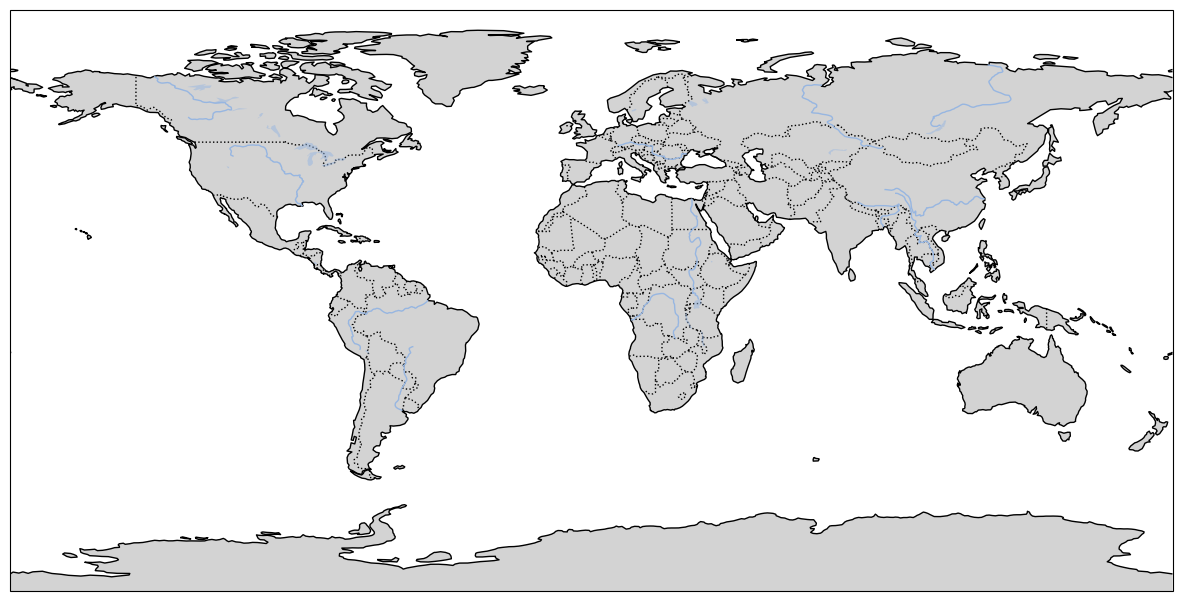

In [21]:
# Plot the connectivity on a real geographical map
plot_spatial_connectivity(
    connectivity=sub_connectivity,
    metadata=sub_metadata,
    center_lon=central_lon,
    center_lat=central_lat,
    radius=sampling_radius
)